In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [621]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len,hidden_layers_len,activation_function):
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.ones((hidden_layers_len[0],input_layer_len)))
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1])))
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1])))
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((1,hidden_layers_len[i])))
            
        
        self.biases.append(np.zeros((1,output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
        self.hidden_layers.append(np.zeros((output_layer_len,1)))
        #self.hidden_layers=[mlp.input_layer]+self.hidden_layers
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        if(memory):
            for i in range(len(self.weights)-1):
                self.hidden_layers[i]=input_layer.dot(self.weights[i].T)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(input_layer.dot(self.weights[i].T)+self.biases[i])
                
                
        output_layer=(input_layer.dot(self.weights[-1].T)+self.biases[-1])[0]
        self.output_layer=output_layer.copy()
        self.hidden_layers[-1]=output_layer.copy()
        
        return(output_layer)
        
    def train(self,input_layer,true_output_layer,rate=0.1):
        
        #feedforward
        output_layer=self.calculate(input_layer,memory=True)
        error=sum((true_output_layer-output_layer)**2)/true_output_layer.shape[0]
        print(error)
        #output error identity function
        errors=[0 for i in range(len(self.weights)-1,-1,-1)]
        errors[-1]=(true_output_layer-output_layer)*output_layer
        for i in range(len(self.weights)-2,-1,-1):
            #derivative of sigmoid
            errors[i]=weights[i].dot(error.T)*sigmoid(hidden_layers[i])*(1-sigmoid(hidden_layers[i]))
        
        #gradient descent
        for i in range(len(self.weights)-1,-1,-1):
            self.weights[i]=self.weights[i]-rate
        

In [39]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [373]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [372]:
sigmoid_derivative(np.ones((1,2)))

array([[0.19661193, 0.19661193]])

In [929]:
mlp=MLP(1,1,[13,14,8],sigmoid)

input_layer=X[0:1000]

true_output_layer=Y[0:1000]

rate=0.001

In [993]:
#feedforward
output_layer=mlp.calculate(input_layer,memory=True)
error=sum((true_output_layer-output_layer)**2)/true_output_layer.shape[0]
print(error)
#output error identity function
errors=[[0]*len(mlp.weights) for x in range(true_output_layer.shape[0])]
for x in range(output_layer.shape[0]):
    errors[x][-1]=(output_layer[x]-true_output_layer[x].T)*output_layer[x]
    
    for i in range(len(mlp.weights)-2,-1,-1):     #derivative of sigmoid
        errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][x])

#gradient
mlp.hidden_layers=[mlp.input_layer]+mlp.hidden_layers
for l in range(len(mlp.weights)):
    gradient=sum([errors[x][l].reshape((-1,1)).dot(mlp.activation_function(mlp.hidden_layers[l][x].reshape((1,-1)))) for x in range(output_layer.shape[0])])
    #print(gradient)
    mlp.weights[l]=mlp.weights[l]-gradient*rate/output_layer.shape[0]
    gradient=sum([errors[x][l].reshape((1,-1)) for x in range(output_layer.shape[0])])
    
    mlp.biases[l]=mlp.biases[l]-gradient*rate/output_layer.shape[0]
    
mlp.hidden_layers.pop(0)

[3067.90123316]


array([[-1.4813543 ],
       [ 1.03326405],
       [-0.07640313],
       [-1.41978545],
       [-0.10839797],
       [-0.87862271],
       [-0.61258272],
       [ 1.69775666],
       [-0.18796626],
       [-0.45082199],
       [ 1.19876609],
       [-1.44989167],
       [-0.83157195],
       [ 1.99757127],
       [-1.43478066],
       [ 1.01258428],
       [ 0.38073632],
       [-0.12986804],
       [ 0.24745898],
       [ 1.96474232],
       [ 0.23170811],
       [ 1.91837538],
       [ 1.11773054],
       [ 0.89576716],
       [ 0.23161451],
       [-1.30918946],
       [ 1.23398787],
       [-0.28798531],
       [-1.42238151],
       [ 0.6797109 ],
       [-1.04632351],
       [-0.87053125],
       [ 0.7273304 ],
       [-0.90943674],
       [-0.23271204],
       [-0.72676423],
       [ 1.39664558],
       [-1.48725041],
       [-0.94869443],
       [ 1.78021493],
       [ 1.17903045],
       [ 1.37571614],
       [-0.61869617],
       [-1.08855497],
       [-1.03504047],
       [-0

4

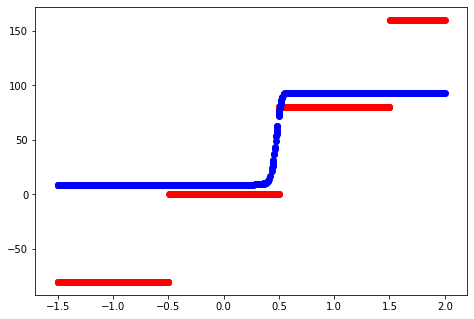

In [994]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(input_layer, true_output_layer, color='r')
ax.scatter(input_layer,output_layer,color="b")

In [891]:
mlp.weights

[array([[-0.24807148],
        [-0.63140467],
        [-0.33123582]]), array([[1.05066933, 0.24393782, 0.67982748],
        [1.35079267, 0.03247807, 1.18629835],
        [0.5679521 , 0.09748388, 0.47545962],
        [1.01170153, 0.50279896, 0.95057849]]), array([[ 0.38924876,  0.49603402, -1.68748979,  0.6690648 ],
        [-0.49498301,  0.28054593, -1.51221408, -0.68722043],
        [-0.69104287,  0.2873488 , -1.50786662,  0.16563053],
        [-0.45046305,  0.18231443, -2.04177997, -0.52274363]]), array([[7.32588078, 7.05547634, 7.31471757, 7.23752742]])]

In [558]:
errors[0][2].dot(mlp.activation_function(mlp.hidden_layers[2-1][0].reshape((1,-1))))

ValueError: shapes (2,) and (1,3) not aligned: 2 (dim 0) != 1 (dim 0)

In [618]:
mlp.hidden_layers

[array([[-1.4813543 ],
        [ 1.03326405],
        [-0.07640313],
        [-1.41978545],
        [-0.10839797],
        [-0.87862271],
        [-0.61258272],
        [ 1.69775666],
        [-0.18796626],
        [-0.45082199]]), array([[-1.61683059, -1.6352775 , -1.68093894],
        [ 0.9677627 ,  0.94680411,  0.93291682],
        [-0.17278347, -0.19263369, -0.22054249],
        [-1.55354844, -1.57205685, -1.61694032],
        [-0.20566865, -0.22548691, -0.25379998],
        [-0.99732663, -1.01637557, -1.05442103],
        [-0.72388347, -0.74319814, -0.77788198],
        [ 1.65074632,  1.62912402,  1.6236331 ],
        [-0.28745111, -0.30718989, -0.33650837],
        [-0.55762138, -0.57709762, -0.60973749]]), array([[ 1.24900421e-02, -1.78579585e-02, -1.68169592e-02,
          3.29763234e-02],
        [ 3.87744668e-01,  1.12474387e+00,  1.14493305e+00,
          9.88517083e-01],
        [ 2.06649453e-01,  5.73488177e-01,  5.83388321e-01,
          5.27763231e-01],
        [ 1.83869

In [519]:
mlp.hidden_layers[3-1][0]

array([2.54179921, 2.54179921])

In [523]:
mlp.weights[3]

array([[0.88569155, 0.58269149]])

In [492]:
mlp.hidden_layers[3-1][0].reshape((-1,1))

array([[2.54179921],
       [2.54179921]])

In [506]:
[errors[x][l+1].dot(mlp.activation_function(mlp.hidden_layers[l][x].reshape((1,-1)))) for x in range(output_layer.shape[0])]

ValueError: shapes (4,) and (1,3) not aligned: 4 (dim 0) != 1 (dim 0)

In [508]:
errors[0][0].dot(mlp.activation_function(mlp.hidden_layers[0][0].reshape((1,-1))))

ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [577]:
errors[0][1].reshape((-1,1)).dot(mlp.hidden_layers[1][0].reshape((1,-1)))

array([[0.11255135, 0.11255135, 0.11255135],
       [0.02308692, 0.02308692, 0.02308692],
       [0.08225534, 0.08225534, 0.08225534],
       [0.08652955, 0.08652955, 0.08652955]])

In [572]:
mlp.hidden_layers[1][0]

array([-1.4813543, -1.4813543, -1.4813543])

In [566]:
mlp.weights

[array([[1.],
        [1.],
        [1.]]), array([[0.02265563, 0.23044865, 0.67955332],
        [0.10940071, 0.62721624, 0.53344188],
        [0.57389517, 0.53777315, 0.81600832],
        [0.30164453, 0.86545132, 0.48275581]]), array([[0.50176763, 0.0630396 , 0.96546198, 0.58981082],
        [0.94521185, 0.20482879, 0.56651333, 0.69086304]]), array([[0.03335412, 0.15109223]])]

In [561]:
[mlp.hidden_layers[x].shape for x in range(5)]

[(10, 1), (10, 3), (10, 4), (10, 2), (10, 1)]

In [550]:
mlp.hidden_layers.insert(0,mlp.input_layer)

In [563]:
mlp.hidden_layers

[array([[-1.4813543 ],
        [ 1.03326405],
        [-0.07640313],
        [-1.41978545],
        [-0.10839797],
        [-0.87862271],
        [-0.61258272],
        [ 1.69775666],
        [-0.18796626],
        [-0.45082199]]), array([[-1.4813543 , -1.4813543 , -1.4813543 ],
        [ 1.03326405,  1.03326405,  1.03326405],
        [-0.07640313, -0.07640313, -0.07640313],
        [-1.41978545, -1.41978545, -1.41978545],
        [-0.10839797, -0.10839797, -0.10839797],
        [-0.87862271, -0.87862271, -0.87862271],
        [-0.61258272, -0.61258272, -0.61258272],
        [ 1.69775666,  1.69775666,  1.69775666],
        [-0.18796626, -0.18796626, -0.18796626],
        [-0.45082199, -0.45082199, -0.45082199]]), array([[0.17274959, 0.23524404, 0.35704995, 0.30559039],
        [0.68787994, 0.93672962, 1.42175445, 1.21684514],
        [0.44852297, 0.61078209, 0.92703609, 0.7934277 ],
        [0.18158398, 0.24727438, 0.37530943, 0.32121823],
        [0.44107897, 0.60064513, 0.91165035, 0

In [559]:
[errors[0][x].shape for x in range(len(errors[0]))]

[(3,), (4,), (2,), (1,)]

In [560]:
[mlp.weights[x].shape for x in range(len(mlp.weights))]

[(3, 1), (4, 3), (2, 4), (1, 2)]

In [445]:
#warstwa przyklad neuron
mlp.hidden_layers[0][0]

array([-1.4813543, -1.4813543, -1.4813543, -1.4813543])

In [324]:
mlp.train(X,Y)

[[6.68602948e-01]
 [6.10105933e-01]
 [3.47440350e-04]
 ...
 [6.10151439e-01]
 [6.10194959e-01]
 [6.10171751e-01]]


In [ ]:
pd.read_csv

In [107]:
test=pd.read_csv("mio1/regression/steps-large-training.csv",delimiter=",")

In [109]:
test=test[["x","y"]]

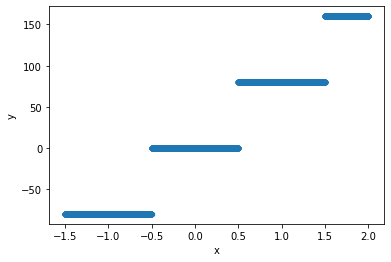

In [114]:
test.plot.scatter(x="x",y="y")

In [263]:
test_mlp=MPL(1,1,[5],sigmoid)

In [264]:
test_mlp.calculate(X)

array([[0.92611473],
       [3.68774105],
       [2.40454252],
       ...,
       [3.46152408],
       [3.2786449 ],
       [3.37272737]])

In [127]:
X=np.vstack(test["x"].to_numpy())

In [177]:
Y_hat=test_mpl.output_layer

In [178]:
Y=np.vstack(test["y"].to_numpy())

In [179]:
sum((Y-Y_hat)**2)

array([70884723.61747867])

In [193]:
np.random.random((1,5))

array([[0.79744999, 0.46417824, 0.5293035 , 0.29351545, 0.87100363]])

In [246]:
Y.min()

-80

In [475]:
test_mlp=MPL(1,1,[5],sigmoid)
test_mlp.calculate(X)
Y_hat=test_mlp.output_layer
highscore=sum((Y-Y_hat)**2)
best_weights=test_mlp.hidden_layers.copy()
best_bias=test_mlp.hidden_layers_bias.copy()
best_output_bias=test_mlp.output_layer_bias.copy()

const=Y.max()-Y.min()

weights=[0,0]
biases=[0]

for i in range(10000):
    weights[0]=np.random.random((1,5))*20-10
    weights[1]=np.random.random((5,1))*20-10
    biases[0]=np.random.random((1,5))*80-40
    out_biases=np.random.random()*const-const/2
    test_mlp.hidden_layers=weights
    test_mlp.hidden_layers_bias=biases
    output_layer_bias=out_biases
    
    test_mlp.calculate(X)
    Y_hat=test_mlp.output_layer
    score=sum((Y-Y_hat)**2)
    #print(score)
    if score<highscore:
        best_weights=test_mlp.hidden_layers
        best_bias=test_mlp.hidden_layers_bias
        best_output_bias=out_biases
        highscore=score
        print(i)
        print(highscore)
        
test_mlp.hidden_layers=best_weights
test_mlp.hidden_layers_bias=best_bias
test_mlp.output_bias=best_output_bias
test_mlp.calculate(X)
Y_hat=test_mlp.output_layer

0
[70694576.36982721]
7
[69367424.46854037]
9
[68858391.64724436]
13
[68576202.36141974]
20
[62742283.65040191]
89
[62729055.40566663]
101
[59218115.99066647]


KeyboardInterrupt: 

In [256]:
highscore

array([57172382.30997805])

In [257]:
test_mlp.hidden_layers_bias

[array([[  2.32891452,  22.4592725 , -30.65948535, -14.05653782,
          10.23792908]])]

In [243]:
test_mlp=MPL(1,1,[5],sigmoid)

test_mlp.hidden_layers[0]=np.array([[1000,1,1,1,1]])
test_mlp.hidden_layers_bias[0]=np.array([[1,1,1,1,1]])


test_mlp.calculate(X)
Y_hat=test_mlp.output_layer

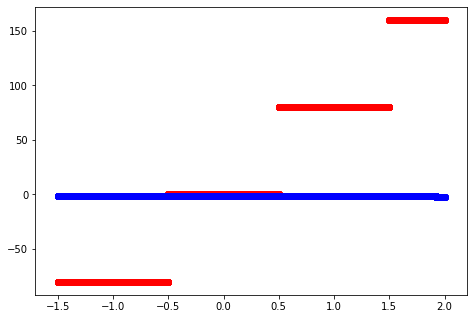

In [258]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color='r')
ax.scatter(X,Y_hat,color="b")